In [57]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from keras import layers, models
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score



(480, 640, 3)


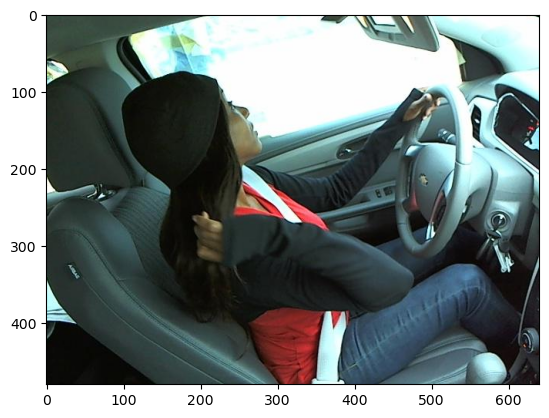

In [58]:
pic=plt.imread("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c8/img_100446.jpg")
plt.imshow(pic, cmap="gray")
print(pic.shape)

In [59]:
DataDirectory = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train'
TestDirectory= '/kaggle/input/state-farm-distracted-driver-detection/imgs/test'
Classes = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
img_size = 101

In [60]:
"""def create_training_data(Classes, Datadirectory, img_size, max_images_per_class=1500):
    training_data = []
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category)
        image_count = 0  # Initialize a counter for images in the class

        for img in os.listdir(path):
            if image_count >= max_images_per_class:
                break  # Stop processing after reaching the maximum number of images per class
            
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            
            # Resize the image while maintaining the aspect ratio
            desired_size = (img_size, img_size)
            height, width = img_array.shape
            aspect_ratio = width / height

            if aspect_ratio >= 1:
                new_width = desired_size[0]
                new_height = int(new_width / aspect_ratio)
            else:
                new_height = desired_size[1]
                new_width = int(new_height * aspect_ratio)

            resized_image = cv2.resize(img_array, (new_width, new_height))

            # Pad the resized image to make it square (img_size x img_size)
            pad_width = (desired_size[1] - new_height) // 2
            pad_height = (desired_size[0] - new_width) // 2
            padded_image = np.pad(resized_image, ((pad_width, pad_width), (pad_height, pad_height)), mode='constant', constant_values=0)

            # Convert the grayscale image to RGB
            rgb_image = cv2.cvtColor(padded_image, cv2.COLOR_GRAY2RGB)
            
            training_data.append([rgb_image, class_num])
            image_count += 1  # Increment the counter for images in the class

    print("Data processing completed.")
    return training_data"""

def create_training_data(Classes, Datadirectory, img_size, max_images_per_class=1500):
    training_data = []
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category)
        image_count = 0  # Initialize a counter for images in the class

        for img in os.listdir(path):
            if image_count >= max_images_per_class:
                break  # Stop processing after reaching the maximum number of images per class
            
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)  # Read images in color
            
            # Resize the image while maintaining the aspect ratio
            resized_image = cv2.resize(img_array, (img_size, img_size))

            training_data.append([resized_image, class_num])
            image_count += 1  # Increment the counter for images in the class

    print("Data processing completed.")
    return training_data


In [61]:
def create_testing_data(TestDirectory, img_size, max_images=8000):
    testing_data = []
    path = os.path.join(TestDirectory, '')
    count = 0  # Initialize a counter

    for img in os.listdir(path):
        if count >= max_images:
            break  # Stop processing after reaching the maximum number of images
        
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        
        # Resize the image while maintaining the aspect ratio
        desired_size = (img_size, img_size)
        height, width = img_array.shape
        aspect_ratio = width / height

        if aspect_ratio >= 1:
            new_width = desired_size[0]
            new_height = int(new_width / aspect_ratio)
        else:
            new_height = desired_size[1]
            new_width = int(new_height * aspect_ratio)

        resized_image = cv2.resize(img_array, (new_width, new_height))

        # Pad the resized image to make it square (img_size x img_size)
        pad_width = (desired_size[1] - new_height) // 2
        pad_height = (desired_size[0] - new_width) // 2
        padded_image = np.pad(resized_image, ((pad_width, pad_width), (pad_height, pad_height)), mode='constant', constant_values=0)

        # Convert the grayscale image to RGB
        rgb_image = cv2.cvtColor(padded_image, cv2.COLOR_GRAY2RGB)

        testing_data.append([rgb_image])
        count += 1  # Increment the counter

    print("Data processing completed.")
    return testing_data


In [ ]:
training_data= create_training_data(Classes, DataDirectory, img_size)

In [ ]:
testing_data= create_testing_data(TestDirectory, img_size)

In [ ]:
random.shuffle(training_data)

In [ ]:
print(len(training_data))
print(len(testing_data))

In [ ]:
X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 3)
Y=np.array(y)


In [ ]:
print(len(Y),len(X))
print(training_data[10000][1])

# Builidng the model

In [ ]:
'''# Define the input shape
input_shape = (240, 240, 3)
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(384, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output from Conv2D layers
model.add(layers.Flatten())

# Add fully connected layers with specified parameters
model.add(layers.Dense(8192, activation='relu'))
model.add(layers.Dense(180, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10,activation='softmax'))'''

In [ ]:
# Define the input shape
input_shape = (102, 102, 3)
model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())  # Add batch normalization
model.add(layers.Dropout(0.5))  # Add dropout for regularization
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))



In [ ]:
model.summary()

In [ ]:
from keras.utils import to_categorical

model.compile(loss="binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=4, mode='max', verbose=1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

Y_train = to_categorical(Y_train,num_classes=10)
Y_val = to_categorical(Y_val,num_classes=10)

In [ ]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping_callback])